# Import & Data Loading

In [1]:
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud
import seaborn as sns
import scipy
from ast import literal_eval
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
import statannotations

## TDA loop caller and required transversion functions

In [2]:
labels = ["0A", "0B", "2A", "2B", "5A", "5B", "8A", "8B"]
L = [pd.read_csv('/gss/home/a.kuznetsov/results_corr/'+name+'.csv') for name in labels]
results = pd.concat(L, ignore_index=True)
results.loc[results.Death == np.inf, 'Death'] = 0.9
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13537, 13538, 13539, 13540, 13541]","[13539, 13540, 13538, 13539, 13540, 13541, 135..."
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5565, 5566, 5567, 5568]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]"
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9095, 9096, 9097, 9098]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]"
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5330, 5331, 5332, 5333]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]"
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7132, 7133, 7134, 7135, 7136, 7137]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713..."
...,...,...,...,...,...,...,...,...,...,...
8877,8B,10,2,0.861404,0.863473,0.002069,9,10,"[11374, 11375, 11376, 11377, 11378, 11381, 113...","[11376, 11383, 11374, 11378, 11382, 11374, 113..."
8878,8B,11,2,0.878021,0.880016,0.001995,8,8,"[11321, 11323, 11324, 11325, 11326, 11327, 113...","[11327, 11321, 11329, 11327, 11328, 11329, 113..."
8879,8B,12,2,0.881608,0.888460,0.006852,7,13,"[9283, 9286, 9287, 9290, 9292, 9294, 9296]","[9294, 9283, 9296, 9290, 9283, 9286, 9290, 928..."
8880,8B,13,2,0.860580,0.863762,0.003182,7,10,"[14239, 14241, 14244, 14245, 14246, 14247, 14249]","[14244, 14239, 14241, 14244, 14247, 14239, 142..."


In [3]:
clr = cooler.Cooler("/gss/home/a.kuznetsov/data_new/0A_2000_down.cool")
clr.chromsizes

name
chr1     4923596
chr2     8484197
chr3     6357299
chr4     5450249
chr5     5125352
chr6     3602379
chrM       55564
chrR       85150
chr2F     161967
chr3F      16660
chrBF      75732
Name: length, dtype: int32

In [4]:
dicty = clr.chromsizes
# A function for bin number to chromosome coordinates conversion.
def bin_to_coor (bin_num, scale_factor = 2000, organism=dicty):
    k = 0
    for i in range(organism.shape[0]):
        if (bin_num - k)* scale_factor > organism[i]:
            k += np.ceil(organism[i] / scale_factor)
            out = 'error'
        else:
            m = bin_num  - k
            if (m + 1) * scale_factor <= organism[i]:
                out = (organism.index[i], int(m * scale_factor), int((m + 1) * scale_factor) )
            else:
                out = (organism.index[i], int(m * scale_factor), organism[i])
            break
    return out

### The expected output would look like in the ex.: 0 → (chr1, 0, 2000)
print(bin_to_coor(0))
print(bin_to_coor(10))
print(bin_to_coor(100))
print(bin_to_coor(1000))
print(bin_to_coor(2461)) # end of the chr I -> len != scale_factor
print(bin_to_coor(10000))
print(bin_to_coor(17173)) # final bin
print(bin_to_coor(17174)) # out of range

('chr1', 0, 2000)
('chr1', 20000, 22000)
('chr1', 200000, 202000)
('chr1', 2000000, 2002000)
('chr1', 4922000, 4923596)
('chr4', 232000, 234000)
('chrBF', 74000, 75732)
error


In [5]:
# A function for chromosome coordinates to bin number conversion.
def coor_to_bin (chr_coor, scale_factor = 2000, organism=dicty):
    if chr_coor[0] not in organism.index:
        return 'error: wrong chromosome name'
    else:
        k = 0
        out = 0
        while chr_coor[0] != organism.index[k]:
            out += np.ceil(organism[k] / scale_factor)
            k += 1
        if (chr_coor[2] > organism[k]) or (chr_coor[2] - chr_coor[1] > scale_factor) or (chr_coor[2] - chr_coor[1] <= 0):
            return 'wrong input coordinates'
        else:
            out += np.ceil(chr_coor[1] / scale_factor)
    return int(out)
### The expected output would look like in the ex.: (chr1, 0, 2000) -> 0
print(coor_to_bin(('chr1', 0, 2000)))
print(coor_to_bin(('chr1', 20000, 22000)))
print(coor_to_bin(('chr1', 200000, 202000)))
print(coor_to_bin(('chr1', 2000000, 2002000)))
print(coor_to_bin(('chr1', 4922000, 4923596))) # end of the chr I
print(coor_to_bin(('chr4', 232000, 234000)))
print(coor_to_bin(('chrBF', 74000, 75732))) # final bin
print(coor_to_bin(('chr1', 5000000, 5002000))) # out of range
print(coor_to_bin(('хромосома_странная', 5000000, 5002000))) # wrong chr name

0
10
100
1000
2461
10000
17173
wrong input coordinates
error: wrong chromosome name


In [6]:
saved_indices = [0]*len(labels)

for i in range(len(labels)):
    saved_indices[i] = np.load('/gss/home/a.kuznetsov/DM_indices/%s_saved.npy' %labels[i])
saved_indices

[array([    7,     8,     9, ..., 17157, 17172, 17173]),
 array([    7,     8,     9, ..., 17157, 17172, 17173]),
 array([    7,     9,    10, ..., 17157, 17172, 17173]),
 array([    7,     8,     9, ..., 17157, 17172, 17173]),
 array([    7,     9,    10, ..., 17157, 17172, 17173]),
 array([    7,     9,    10, ..., 17157, 17172, 17173]),
 array([    7,     8,     9, ..., 17157, 17172, 17173]),
 array([    7,     8,     9, ..., 17157, 17172, 17173])]

In [7]:
saved_indices[0].shape

(15122,)

In [8]:
# A function for conversion between complete and filtered matrices with deleted bins.
def dist_to_cont_bin (replica_num, bin_num):
    if len(saved_indices) > replica_num:
        if len(saved_indices[replica_num]) > bin_num:
            return saved_indices[replica_num][bin_num]
        else: 
            print("There's no bin with the number %s in the saved bins for that replica." %bin_num)
            return np.nan 
    else: 
        print("There's no replica with the number %s." %replica_num)
        return np.nan 
print(dist_to_cont_bin(1, 15147))
print(bin_to_coor (dist_to_cont_bin(1, 15147)))
print(dist_to_cont_bin(1, 15148))

17173
('chrBF', 74000, 75732)
There's no bin with the number 15148 in the saved bins for that replica.
nan


In [9]:
# A function for conversion between filtered matrices with deleted bins and complete ones.
def cont_to_dist_bin (replica_num, bin_num):
    try:
        return int(np.where(saved_indices[replica_num] == bin_num)[0])
    except:
        return "Wrong bin or replica number."
print(cont_to_dist_bin(1, 17173))
print(cont_to_dist_bin(1, coor_to_bin(('chrBF', 74000, 75732))))
print(cont_to_dist_bin(1, 17174))


15147
15147
Wrong bin or replica number.


In [10]:
results = results.loc[results.Dim == 1]
results.Vertices = results.Vertices.apply(lambda x: literal_eval(x))
results.Vertices = results.Vertices.apply(lambda x: [k-1 for k in x])

results['start_bin'] = results.Vertices.apply(lambda x: x[0])
results['end_bin'] = results.Vertices.apply(lambda x: x[-1])
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,start_bin,end_bin
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",13536,13540
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",5564,5567
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",9094,9097
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",5329,5332
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",7131,7136
...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.900000,inf,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",14443,14486
8864,8B,1129,1,0.819414,0.900000,inf,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",8265,8276
8865,8B,1130,1,0.810492,0.900000,inf,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",4631,4693
8866,8B,1131,1,0.810340,0.900000,inf,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",14422,14483


In [11]:
results['start1'] = np.nan
results['end1'] = np.nan
results['chrom1'] = ''
results['start2'] = np.nan
results['end2'] = np.nan
results['chrom2'] = ''
for count, val in enumerate(labels):
    results.loc[results.Replica == val, 'start'] = results.loc[results.Replica == val, 
                                                                'start_bin'].apply(lambda x: 
                                                                                   bin_to_coor(dist_to_cont_bin(count, x)))
    results.loc[results.Replica == val, 'end'] = results.loc[results.Replica == val, 
                                                                'end_bin'].apply(lambda x: 
                                                                                   bin_to_coor(dist_to_cont_bin(count, x)))
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,start_bin,end_bin,start1,end1,chrom1,start2,end2,chrom2,start,end
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",13536,13540,NaN,NaN,,NaN,NaN,,"(chr6, 300000, 302000)","(chr6, 308000, 310000)"
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",5564,5567,NaN,NaN,,NaN,NaN,,"(chr3, 246000, 248000)","(chr3, 252000, 254000)"
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",9094,9097,NaN,NaN,,NaN,NaN,,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)"
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",5329,5332,NaN,NaN,,NaN,NaN,,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)"
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",7131,7136,NaN,NaN,,NaN,NaN,,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.900000,inf,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",14443,14486,NaN,NaN,,NaN,NaN,,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)"
8864,8B,1129,1,0.819414,0.900000,inf,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",8265,8276,NaN,NaN,,NaN,NaN,,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)"
8865,8B,1130,1,0.810492,0.900000,inf,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",4631,4693,NaN,NaN,,NaN,NaN,,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)"
8866,8B,1131,1,0.810340,0.900000,inf,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",14422,14483,NaN,NaN,,NaN,NaN,,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)"


In [12]:
results['start1'] = results.start.apply(lambda x: x[1])
results['end1'] = results.start.apply(lambda x: x[2])
results['chrom1'] = results.start.apply(lambda x: x[0])
results['start2'] = results.end.apply(lambda x: x[1])
results['end2'] = results.end.apply(lambda x: x[2])
results['chrom2'] = results.end.apply(lambda x: x[0])
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,start_bin,end_bin,start1,end1,chrom1,start2,end2,chrom2,start,end
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",13536,13540,300000,302000,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)"
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",5564,5567,246000,248000,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)"
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",9094,9097,1416000,1418000,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)"
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",5329,5332,8220000,8222000,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)"
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",7131,7136,3574000,3576000,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.900000,inf,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",14443,14486,2002000,2004000,chr6,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)"
8864,8B,1129,1,0.819414,0.900000,inf,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",8265,8276,5836000,5838000,chr3,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)"
8865,8B,1130,1,0.810492,0.900000,inf,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",4631,4693,6642000,6644000,chr2,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)"
8866,8B,1131,1,0.810340,0.900000,inf,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",14422,14483,1956000,1958000,chr6,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)"


In [13]:
results.head()

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,start_bin,end_bin,start1,end1,chrom1,start2,end2,chrom2,start,end
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",13536,13540,300000,302000,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)"
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",5564,5567,246000,248000,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)"
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",9094,9097,1416000,1418000,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)"
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",5329,5332,8220000,8222000,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)"
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",7131,7136,3574000,3576000,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)"


In [14]:
results.loc[results.Replica == '0B', 'end_bin']

888      7380
889      7834
890      6974
891      7828
892      2587
        ...  
1755    15138
1756    15140
1757    15138
1758    15119
1759    14363
Name: end_bin, Length: 872, dtype: int64

## SIP results

In [15]:
sip = []
for label in labels:
    temp_df = pd.read_csv(f'/gss/home/a.kuznetsov/SIP_results/{label}/2kbLoops.txt', sep='\t')
    temp_df['Replica'] = label
    sip.append(temp_df)
sip = pd.concat(sip, ignore_index=True)
sip

,chromosome1,x1,x2,chromosome2,y1,y2,color,APScoreAvg,ProbabilityofEnrichment,RegAPScoreAvg,Avg_diffMaxNeihgboor_1,Avg_diffMaxNeihgboor_2,avg,std,value,Replica
0,chr5,3380000,3382000,chr5,3406000,3408000,"0,0,0",4.401653,1.000000,2.016141,1.958290,1.961969,1.732468,1.329493,3.473170,0A
1,chr5,4618000,4620000,chr5,4664000,4666000,"0,0,0",3.981753,1.000000,2.092744,1.639782,1.880253,2.184980,0.633806,3.642564,0A
2,chr5,3952000,3954000,chr5,3986000,3988000,"0,0,0",4.558865,1.000000,2.494575,1.620347,1.786359,2.229638,1.584143,3.669947,0A
3,chr5,4570000,4572000,chr5,4602000,4604000,"0,0,0",5.605504,1.000000,3.204686,0.875773,1.328879,1.861599,0.389970,2.640064,0A
4,chr5,2202000,2204000,chr5,2232000,2234000,"0,0,0",4.612131,1.000000,2.363610,1.474594,1.673027,1.853423,0.657949,3.164173,0A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,chr2,484000,486000,chr2,516000,518000,"0,0,0",6.514333,1.000000,4.039567,1.385832,1.555028,2.555201,0.937078,3.787051,8B
401,chr2,764000,766000,chr2,802000,804000,"0,0,0",6.874113,1.000000,3.963069,1.850295,2.472770,3.490534,1.209043,5.135241,8B
402,chr2,8308000,8310000,chr2,8368000,8370000,"0,0,0",13.794765,1.000000,5.481322,10.741370,13.472381,10.462937,6.773092,20.010820,8B
403,chr2,6270000,6272000,chr2,6306000,6308000,"0,0,0",6.400930,0.998384,3.686400,2.283813,3.117628,4.398162,1.095169,6.428218,8B


In [16]:
sip = sip.rename(columns={"chromosome1": "chrom1", "chromosome2": "chrom2", 
                          "x1": "start1", "y1": "start2", "x2": "end1", "y2": "end2", })
sip


,chrom1,start1,end1,chrom2,start2,end2,color,APScoreAvg,ProbabilityofEnrichment,RegAPScoreAvg,Avg_diffMaxNeihgboor_1,Avg_diffMaxNeihgboor_2,avg,std,value,Replica
0,chr5,3380000,3382000,chr5,3406000,3408000,"0,0,0",4.401653,1.000000,2.016141,1.958290,1.961969,1.732468,1.329493,3.473170,0A
1,chr5,4618000,4620000,chr5,4664000,4666000,"0,0,0",3.981753,1.000000,2.092744,1.639782,1.880253,2.184980,0.633806,3.642564,0A
2,chr5,3952000,3954000,chr5,3986000,3988000,"0,0,0",4.558865,1.000000,2.494575,1.620347,1.786359,2.229638,1.584143,3.669947,0A
3,chr5,4570000,4572000,chr5,4602000,4604000,"0,0,0",5.605504,1.000000,3.204686,0.875773,1.328879,1.861599,0.389970,2.640064,0A
4,chr5,2202000,2204000,chr5,2232000,2234000,"0,0,0",4.612131,1.000000,2.363610,1.474594,1.673027,1.853423,0.657949,3.164173,0A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,chr2,484000,486000,chr2,516000,518000,"0,0,0",6.514333,1.000000,4.039567,1.385832,1.555028,2.555201,0.937078,3.787051,8B
401,chr2,764000,766000,chr2,802000,804000,"0,0,0",6.874113,1.000000,3.963069,1.850295,2.472770,3.490534,1.209043,5.135241,8B
402,chr2,8308000,8310000,chr2,8368000,8370000,"0,0,0",13.794765,1.000000,5.481322,10.741370,13.472381,10.462937,6.773092,20.010820,8B
403,chr2,6270000,6272000,chr2,6306000,6308000,"0,0,0",6.400930,0.998384,3.686400,2.283813,3.117628,4.398162,1.095169,6.428218,8B


## Chromosight results

In [17]:
chromosight = []
for label in labels:
    temp_df = pd.read_csv(f'/gss/home/a.kuznetsov/chromosight_results/cis_only/chromosight_{label}.tsv', sep='\t')
    temp_df['Replica'] = label
    chromosight.append(temp_df)
chromosight = pd.concat(chromosight).reset_index()
chromosight

,index,chrom1,start1,end1,chrom2,start2,end2,bin1,bin2,kernel_id,iteration,score,pvalue,qvalue,Replica
0,0,chr1,210000,212000,chr1,224000,226000,105,112,0,0,0.418039,8.000000e-10,1.000000e-09,0A
1,1,chr1,226000,228000,chr1,244000,246000,113,122,0,0,0.550879,0.000000e+00,0.000000e+00,0A
2,2,chr1,248000,250000,chr1,286000,288000,124,143,0,0,0.377110,1.000000e-10,1.000000e-10,0A
3,3,chr1,250000,252000,chr1,270000,272000,125,135,0,0,0.314182,5.259000e-07,5.599000e-07,0A
4,4,chr1,306000,308000,chr1,322000,324000,153,161,0,0,0.404150,0.000000e+00,0.000000e+00,0A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,962,chr6,3502000,3504000,chr6,3518000,3520000,16924,16932,0,0,0.420055,0.000000e+00,1.000000e-10,8B
7814,963,chr6,3534000,3536000,chr6,3562000,3564000,16940,16954,0,0,0.632248,0.000000e+00,0.000000e+00,8B
7815,964,chr6,3562000,3564000,chr6,3576000,3578000,16954,16961,0,0,0.457702,0.000000e+00,0.000000e+00,8B
7816,965,chrM,12000,14000,chrM,50000,52000,16981,17000,0,0,0.356037,1.612000e-07,1.771000e-07,8B


# Lasca results

In [18]:
lasca = []
for lab in ['0A', '2A', '5A', '8A']:
    temp_df = pd.read_csv(f'/gss/home/a.kuznetsov/{lab}B_dist_20_size_3_intensity_q=02.bed', 
                          sep='\t').rename(columns={'chrom':'chrom1', 'start2':'end1', 'end1':'start2'})
    temp_df['chrom2'] = temp_df['chrom1']
    temp_df['Replica'] = lab[0]+'B'
    lasca.append(temp_df)
lasca = pd.concat(lasca).reset_index()
lasca

,index,chrom1,start1,end1,start2,end2,chrom2,Replica
0,0,chr1,10000,12000,14000,16000,chr1,0B
1,1,chr1,14000,16000,18000,20000,chr1,0B
2,2,chr1,24000,26000,26000,28000,chr1,0B
3,3,chr1,202000,204000,204000,206000,chr1,0B
4,4,chr1,196000,198000,224000,226000,chr1,0B
...,...,...,...,...,...,...,...,...
7612,1906,chr6,3534000,3536000,3560000,3562000,chr6,8B
7613,1907,chr6,3544000,3546000,3548000,3550000,chr6,8B
7614,1908,chr6,3576000,3578000,3578000,3580000,chr6,8B
7615,1909,chr6,3566000,3568000,3592000,3594000,chr6,8B


# Results matching

In [19]:
def match_loops (df1, df2, window_size=0, scaling_factor=2000):
    '''
    func for loop intersection
    :params df1, df2: pd.DataFrames with columns chrom1 & 2, start1 & 2, Replica
    :param window_size: int, window for loop, loops are intersected  
                        iff abs(start1 for df1 - start1 for df2) <= window_size & same for start2 with corresponding chromosomes
    returns: a subset of df1 indices with intersecting loop starts' intersection
    '''
    idx = []
    for ind in df1.index:
        temp = df2.loc[(df2['Replica'] == df1.loc[ind, 'Replica']) 
                   & (df2['chrom1'] == df1.loc[ind, 'chrom1']) 
                   & (df2['chrom2'] == df1.loc[ind, 'chrom2']) 
                   & (abs(df1.loc[ind, 'start1']-df2['start1']) <= window_size*scaling_factor)
                   & (abs(df1.loc[ind, 'start2']-df2['start2']) <= window_size*scaling_factor)]
        if len(temp.index) != 0:
            idx.append(ind)
    return idx

In [20]:
len(sip)

405

In [21]:
len(chromosight)

7818

In [22]:
len(results)

8809

In [23]:
len(lasca)

7617

In [24]:
len(match_loops (sip, chromosight, window_size=0))

88

In [25]:
len(match_loops (chromosight, sip, window_size=1))

318

In [26]:
len(match_loops (sip, chromosight, window_size=1))

318

In [27]:
len(match_loops (chromosight, sip, window_size=2))

354

In [28]:
len(match_loops (sip, chromosight, window_size=2))

354

In [29]:
len(match_loops (chromosight, results, window_size=0))

410

In [30]:
len(match_loops (sip, results, window_size=0))

43

In [31]:
len(match_loops (chromosight, results, window_size=1))

2105

In [32]:
len(match_loops (sip, results, window_size=1))

143

In [33]:
len(match_loops (sip, results, window_size=2))

204

In [34]:
idx = match_loops (results, chromosight, window_size=2)

In [35]:
len(idx)

3195

In [36]:
len(match_loops (sip, lasca, window_size=0))

19

In [37]:
len(match_loops (sip, lasca, window_size=1))

77

In [38]:
len(match_loops (sip, lasca, window_size=2))

112

# Feature Extraction and Importance

In [39]:
results['y'] = 0
results.loc[idx, 'y'] = 1
results.y

0       1
1       0
2       0
3       0
4       0
       ..
8863    0
8864    1
8865    0
8866    0
8867    1
Name: y, Length: 8809, dtype: int64

In [40]:
all_distances = [0]*len(labels)
for i in range(len(labels)):
    all_distances[i] = np.load('/gss/home/a.kuznetsov/NoNAN_DM_new/%s.npy' %labels[i])
all_distances

[array([[0.00000000e+00, 4.51359710e-01, 5.34237871e-01, ...,
         9.69576575e-01, 9.99598289e-01, 9.91810244e-01],
        [4.51359710e-01, 1.05367121e-08, 3.70335852e-01, ...,
         9.49707239e-01, 9.99133881e-01, 9.89830431e-01],
        [5.34237871e-01, 3.70335852e-01, 1.05367121e-08, ...,
         9.63733752e-01, 9.98741070e-01, 9.84978123e-01],
        ...,
        [9.69576575e-01, 9.49707239e-01, 9.63733752e-01, ...,
         0.00000000e+00, 9.88172476e-01, 9.87788419e-01],
        [9.99598289e-01, 9.99133881e-01, 9.98741070e-01, ...,
         9.88172476e-01, 0.00000000e+00, 3.74800787e-01],
        [9.91810244e-01, 9.89830431e-01, 9.84978123e-01, ...,
         9.87788419e-01, 3.74800787e-01, 1.05367121e-08]]),
 array([[0.00000000e+00, 5.22158793e-01, 5.26604764e-01, ...,
         9.67854269e-01, 9.99049363e-01, 9.95185502e-01],
        [5.22158793e-01, 0.00000000e+00, 3.75329207e-01, ...,
         9.51398741e-01, 9.99040810e-01, 9.93188996e-01],
        [5.26604764e-01, 

In [41]:
testt = all_distances[0][[13536, 13537, 13538, 13539, 13540, ], :][:, [13536, 13537, 13538, 13539, 13540,]]
testt

array([[0.        , 0.45933778, 0.5310986 , 0.55627576, 0.50381116],
       [0.45933778, 0.        , 0.3563267 , 0.44281815, 0.52497076],
       [0.5310986 , 0.3563267 , 0.        , 0.16212593, 0.36368103],
       [0.55627576, 0.44281815, 0.16212593, 0.        , 0.26938608],
       [0.50381116, 0.52497076, 0.36368103, 0.26938608, 0.        ]])

In [42]:
def bottleneck_death(dist_matrix, loops_df):
    d = []
    for ind in loops_df.index:
        vert = loops_df.loc[ind, 'Vertices']
        temp_dist_m = dist_matrix[vert, :][:, vert]
        d.append(np.amax(temp_dist_m, axis=1).min())
    return d

In [43]:
for i, label in enumerate(labels):
    results.loc[results.Replica == label, 'Death'] = bottleneck_death(all_distances[i], results.loc[results.Replica == label])
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,end_bin,start1,end1,chrom1,start2,end2,chrom2,start,end,y
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,13540,300000,302000,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,5567,246000,248000,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,9097,1416000,1418000,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,5332,8220000,8222000,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,7136,3574000,3576000,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,inf,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,14486,2002000,2004000,chr6,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0
8864,8B,1129,1,0.819414,0.922298,inf,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,8276,5836000,5838000,chr3,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1
8865,8B,1130,1,0.810492,0.983216,inf,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,4693,6642000,6644000,chr2,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0
8866,8B,1131,1,0.810340,0.955173,inf,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,14483,1956000,1958000,chr6,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0


In [44]:
results['Lifetime'] = results['Death'] - results['Birth']
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,end_bin,start1,end1,chrom1,start2,end2,chrom2,start,end,y
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,13540,300000,302000,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,5567,246000,248000,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,9097,1416000,1418000,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,5332,8220000,8222000,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,7136,3574000,3576000,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,0.152987,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,14486,2002000,2004000,chr6,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0
8864,8B,1129,1,0.819414,0.922298,0.102884,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,8276,5836000,5838000,chr3,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1
8865,8B,1130,1,0.810492,0.983216,0.172724,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,4693,6642000,6644000,chr2,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0
8866,8B,1131,1,0.810340,0.955173,0.144833,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,14483,1956000,1958000,chr6,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0


In [45]:
def maxrad(dist_matrix, loops_df):
    maxrad = []
    for ind in loops_df.index:
        vert = loops_df.loc[ind, 'Vertices']
        temp_dist_m = dist_matrix[vert, :][:, vert]
        maxrad.append(temp_dist_m.max())
    return maxrad

In [46]:
maxrad(all_distances[0], results.head())

[0.5562757608265805,
 0.5754209447112468,
 0.6429667907405411,
 0.6213535445748996,
 0.6395773563156965]

In [47]:
results['Max_Rad'] = 0
for i, label in enumerate(labels):
    results.loc[results.Replica == label, 'Max_Rad'] = maxrad(all_distances[i], results.loc[results.Replica == label])
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,start1,end1,chrom1,start2,end2,chrom2,start,end,y,Max_Rad
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,300000,302000,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1,0.556276
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,246000,248000,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0,0.575421
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,1416000,1418000,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0,0.642967
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,8220000,8222000,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0,0.621354
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,3574000,3576000,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0,0.639577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,0.152987,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,2002000,2004000,chr6,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0,0.996196
8864,8B,1129,1,0.819414,0.922298,0.102884,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,5836000,5838000,chr3,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1,0.991829
8865,8B,1130,1,0.810492,0.983216,0.172724,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,6642000,6644000,chr2,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0,0.995116
8866,8B,1131,1,0.810340,0.955173,0.144833,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,1956000,1958000,chr6,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0,0.997328


In [48]:
results['Lifetime_Cech'] = 0
results['Lifetime_Cech'] = results['Max_Rad'] - results['Birth']
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,end1,chrom1,start2,end2,chrom2,start,end,y,Max_Rad,Lifetime_Cech
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,302000,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1,0.556276,0.052465
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,248000,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0,0.575421,0.045825
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,1418000,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0,0.642967,0.089718
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,8222000,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0,0.621354,0.047231
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,3576000,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0,0.639577,0.053037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,0.152987,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,2004000,chr6,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0,0.996196,0.172349
8864,8B,1129,1,0.819414,0.922298,0.102884,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,5838000,chr3,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1,0.991829,0.172415
8865,8B,1130,1,0.810492,0.983216,0.172724,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,6644000,chr2,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0,0.995116,0.184624
8866,8B,1131,1,0.810340,0.955173,0.144833,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,1958000,chr6,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0,0.997328,0.186988


In [49]:
def loop_perimeter(dist_matrix, loops_df):
    per = []
    for ind in loops_df.index:
        vert = loops_df.loc[ind, 'Vertices']
        temp_dist_m = dist_matrix[vert, :][:, vert]
        per.append(np.sum(np.diagonal(temp_dist_m, offset=1))+temp_dist_m[0, -1])
    return per

In [50]:
results['Perimeter'] = 0
for i, label in enumerate(labels):
    results.loc[results.Replica == label, 'Perimeter'] = loop_perimeter(all_distances[i], results.loc[results.Replica == label])
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,chrom1,start2,end2,chrom2,start,end,y,Max_Rad,Lifetime_Cech,Perimeter
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,chr6,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1,0.556276,0.052465,1.750988
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,chr3,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0,0.575421,0.045825,1.860504
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,chr4,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0,0.642967,0.089718,1.998014
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,chr2,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0,0.621354,0.047231,1.873681
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,chr3,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0,0.639577,0.053037,2.474224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,0.152987,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,chr6,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0,0.996196,0.172349,17.803262
8864,8B,1129,1,0.819414,0.922298,0.102884,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,chr3,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1,0.991829,0.172415,7.372233
8865,8B,1130,1,0.810492,0.983216,0.172724,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,chr2,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0,0.995116,0.184624,21.946577
8866,8B,1131,1,0.810340,0.955173,0.144833,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,chr6,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0,0.997328,0.186988,10.455082


In [51]:
results['Perimeter_Normalized'] = 0
results['Perimeter_Normalized'] = results['Perimeter'] / results['Numvert']
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,start2,end2,chrom2,start,end,y,Max_Rad,Lifetime_Cech,Perimeter,Perimeter_Normalized
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,308000,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1,0.556276,0.052465,1.750988,0.350198
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,252000,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0,0.575421,0.045825,1.860504,0.465126
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,1422000,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0,0.642967,0.089718,1.998014,0.499504
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,8226000,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0,0.621354,0.047231,1.873681,0.468420
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,3584000,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0,0.639577,0.053037,2.474224,0.412371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,0.152987,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,2094000,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0,0.996196,0.172349,17.803262,0.523625
8864,8B,1129,1,0.819414,0.922298,0.102884,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,5858000,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1,0.991829,0.172415,7.372233,0.670203
8865,8B,1130,1,0.810492,0.983216,0.172724,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,6766000,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0,0.995116,0.184624,21.946577,0.466948
8866,8B,1131,1,0.810340,0.955173,0.144833,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,2088000,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0,0.997328,0.186988,10.455082,0.497861


In [52]:
def internal_edges_sum(dist_matrix, loops_df):
    diam = []
    for ind in loops_df.index:
        vert = loops_df.loc[ind, 'Vertices']
        temp_dist_m = dist_matrix[vert, :][:, vert]
        diam.append(temp_dist_m.sum() / 2 - loops_df.loc[ind, 'Perimeter'])
    return diam

In [53]:
results['Internal_Edges'] = 0
for i, label in enumerate(labels):
    results.loc[results.Replica == label, 'Internal_Edges'] = internal_edges_sum(all_distances[i], results.loc[results.Replica == label])
results

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,end2,chrom2,start,end,y,Max_Rad,Lifetime_Cech,Perimeter,Perimeter_Normalized,Internal_Edges
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,310000,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1,0.556276,0.052465,1.750988,0.350198,2.418844
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,254000,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0,0.575421,0.045825,1.860504,0.465126,1.136167
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,1424000,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0,0.642967,0.089718,1.998014,0.499504,1.221585
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,8228000,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0,0.621354,0.047231,1.873681,0.468420,1.206647
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,3586000,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0,0.639577,0.053037,2.474224,0.412371,5.232954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,8B,1128,1,0.823848,0.976834,0.152987,34,43,"[14443, 14444, 14445, 14447, 14450, 14452, 144...","[14454, 14453, 14474, 14475, 14470, 14469, 144...",...,2096000,chr6,"(chr6, 2002000, 2004000)","(chr6, 2094000, 2096000)",0,0.996196,0.172349,17.803262,0.523625,477.603612
8864,8B,1129,1,0.819414,0.922298,0.102884,11,11,"[8265, 8267, 8268, 8269, 8270, 8271, 8272, 827...","[8270, 8269, 8271, 8272, 8269, 8268, 8273, 827...",...,5860000,chr3,"(chr3, 5836000, 5838000)","(chr3, 5858000, 5860000)",1,0.991829,0.172415,7.372233,0.670203,39.986913
8865,8B,1130,1,0.810492,0.983216,0.172724,47,62,"[4631, 4632, 4633, 4634, 4635, 4636, 4637, 463...","[4633, 4634, 4661, 4660, 4657, 4658, 4685, 468...",...,6768000,chr2,"(chr2, 6642000, 6644000)","(chr2, 6766000, 6768000)",0,0.995116,0.184624,21.946577,0.466948,946.176921
8866,8B,1131,1,0.810340,0.955173,0.144833,21,61,"[14422, 14423, 14424, 14425, 14426, 14427, 144...","[14424, 14423, 14428, 14427, 14438, 14437, 144...",...,2090000,chr6,"(chr6, 1956000, 1958000)","(chr6, 2088000, 2090000)",0,0.997328,0.186988,10.455082,0.497861,170.065484


In [54]:
results['Mean_Diameter'] = 0
results['Mean_Diameter'] = 2 * results['Internal_Edges'] / (results['Numvert'] - 3) / results['Numvert']
results.head()

,Replica,Class,Dim,Birth,Death,Lifetime,Numvert,Range,Vertices,Unsorted_Vertices,...,chrom2,start,end,y,Max_Rad,Lifetime_Cech,Perimeter,Perimeter_Normalized,Internal_Edges,Mean_Diameter
0,0A,1,1,0.503811,0.524971,0.021160,5,4,"[13536, 13537, 13538, 13539, 13540]","[13539, 13540, 13538, 13539, 13540, 13541, 135...",...,chr6,"(chr6, 300000, 302000)","(chr6, 308000, 310000)",1,0.556276,0.052465,1.750988,0.350198,2.418844,0.483769
1,0A,2,1,0.529596,0.560746,0.031150,4,3,"[5564, 5565, 5566, 5567]","[5567, 5568, 5566, 5565, 5567, 5566, 5568, 5565]",...,chr3,"(chr3, 246000, 248000)","(chr3, 252000, 254000)",0,0.575421,0.045825,1.860504,0.465126,1.136167,0.568084
2,0A,3,1,0.553249,0.578618,0.025370,4,3,"[9094, 9095, 9096, 9097]","[9097, 9098, 9096, 9095, 9097, 9096, 9098, 9095]",...,chr4,"(chr4, 1416000, 1418000)","(chr4, 1422000, 1424000)",0,0.642967,0.089718,1.998014,0.499504,1.221585,0.610793
3,0A,4,1,0.574123,0.585293,0.011170,4,3,"[5329, 5330, 5331, 5332]","[5332, 5333, 5331, 5330, 5331, 5332, 5330, 5333]",...,chr2,"(chr2, 8220000, 8222000)","(chr2, 8226000, 8228000)",0,0.621354,0.047231,1.873681,0.468420,1.206647,0.603323
4,0A,5,1,0.586540,0.593052,0.006512,6,5,"[7131, 7132, 7133, 7134, 7135, 7136]","[7135, 7134, 7136, 7137, 7133, 7132, 7134, 713...",...,chr3,"(chr3, 3574000, 3576000)","(chr3, 3584000, 3586000)",0,0.639577,0.053037,2.474224,0.412371,5.232954,0.581439


In [55]:
results.columns

Index(['Replica', 'Class', 'Dim', 'Birth', 'Death', 'Lifetime', 'Numvert',
       'Range', 'Vertices', 'Unsorted_Vertices', 'start_bin', 'end_bin',
       'start1', 'end1', 'chrom1', 'start2', 'end2', 'chrom2', 'start', 'end',
       'y', 'Max_Rad', 'Lifetime_Cech', 'Perimeter', 'Perimeter_Normalized',
       'Internal_Edges', 'Mean_Diameter'],
      dtype='object')

In [56]:
results = results.loc[results.chrom2 == results.chrom1]

In [57]:
results['Perimeter_log'] = np.log10(results['Perimeter'])
results['Internal_Edges_log'] = np.log10(results['Internal_Edges'])
results['Numvert_log'] = np.log10(results['Numvert'])
results['Range_log'] = np.log10(results['Range'])


In [59]:
df = results.sample(results.shape[0])
X, y = df[['Birth', 'Lifetime',   'Lifetime_Cech', 'Numvert_log', 'Range_log', 'Perimeter_Normalized', 'Mean_Diameter']], df['y']

In [60]:
X.describe()

,Birth,Lifetime,Lifetime_Cech,Numvert_log,Range_log,Perimeter_Normalized,Mean_Diameter
count,8775.000000,8775.000000,8775.000000,8775.000000,8775.000000,8775.000000,8775.000000
mean,0.804588,0.035066,0.088197,0.824492,0.811018,0.633789,0.830566
std,0.072370,0.030468,0.044685,0.176985,0.230090,0.089788,0.074632
min,0.346099,0.000003,0.000543,0.602060,0.477121,0.192154,0.389857
25%,0.764110,0.010792,0.054455,0.698970,0.602060,0.579192,0.787834
50%,0.822698,0.026614,0.086067,0.778151,0.845098,0.648336,0.849977
75%,0.860219,0.052481,0.117564,0.954243,1.000000,0.696785,0.886767
max,0.899972,0.229610,0.354165,2.806858,3.033826,0.873739,0.989732


In [61]:
from statannot import add_stat_annotation


0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=6.967e-01 U_stat=8.855e+06


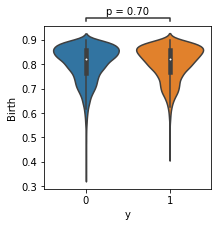

0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=1.000e+00 U_stat=5.780e+06


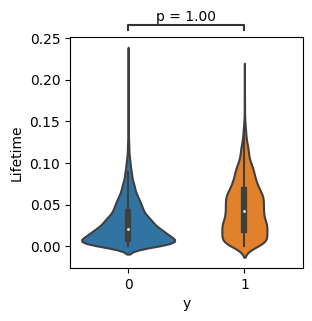

0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=1.000e+00 U_stat=5.667e+06


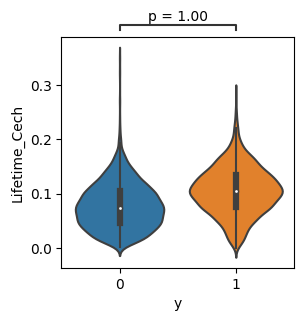

0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=1.000e+00 U_stat=3.542e+06


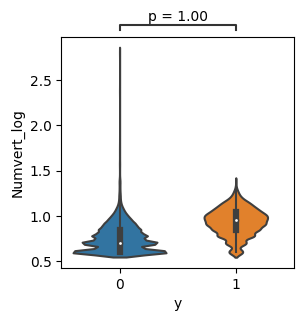

0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=1.000e+00 U_stat=3.010e+06


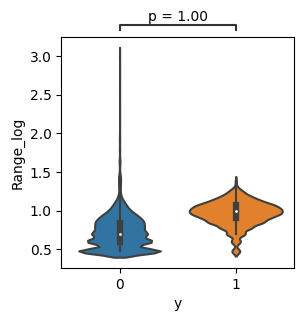

0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=1.068e-141 U_stat=1.180e+07


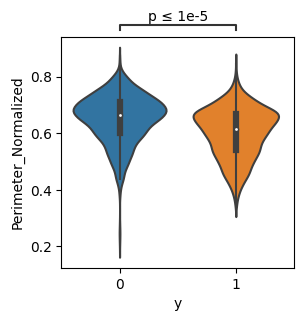

0 v.s. 1: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val=7.893e-01 U_stat=8.822e+06


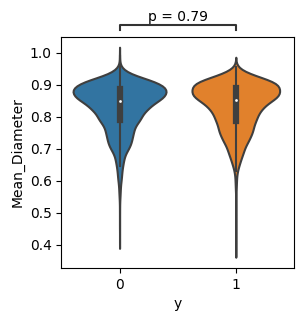

In [62]:
for col in X.columns:
    plt.figure(figsize = (3, 3))
    plt.rcParams["figure.dpi"] = 500
    plt.style.use('default')
    ax = sns.violinplot(x=y, y=col, data=results)
    add_stat_annotation(ax, x=results['y'].astype('str'), y=results[col], order=['0', '1'],
                    box_pairs=[('0', '1')],
                    test='Mann-Whitney-gt', text_format='simple', loc='outside', verbose=2)
    plt.show()


In [63]:
X_train = X.loc[df.loc[df.Replica.isin(['0A', '2A', '5A', '8A'])].index]
X_test = X.loc[df.loc[~df.Replica.isin(['0A', '2A', '5A', '8A'])].index]
y_train = y.loc[df.loc[df.Replica.isin(['0A', '2A', '5A', '8A'])].index]
y_test = y.loc[df.loc[~df.Replica.isin(['0A', '2A', '5A', '8A'])].index]

In [64]:
# model = RandomForestClassifier()
# parametrs={'criterion':['gini', 'entropy'], 'max_depth': range(1, 20), 'min_samples_split': range(2, 6), 'min_samples_leaf': range(1, 5), 'n_estimators':[100, 200], }
# grid_search_cv_clf=GridSearchCV(model, parametrs, cv=5, verbose=2, n_jobs=4)
#best ones:
model = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2, min_samples_split=2,
                       n_estimators=200)

# grid_search_cv_clf.fit(X_train, y_train)
model.fit(X_train, y_train)
# grid_search_cv_clf.best_params_


# model.fit(X_train, y_train)
res = cross_validate(model, X_train, y_train, cv=5, scoring='accuracy', return_estimator=True)
res['estimator'][3].feature_importances_

array([0.07734182, 0.09450117, 0.10121835, 0.19504402, 0.35253164,
       0.10287866, 0.07648435])

In [65]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

NameError: name 'grid_search_cv_clf' is not defined

In [ ]:
model.score(X_test, y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, model.predict(X_test))


In [ ]:
recall_score(y_test, best_clf.predict(X_test))


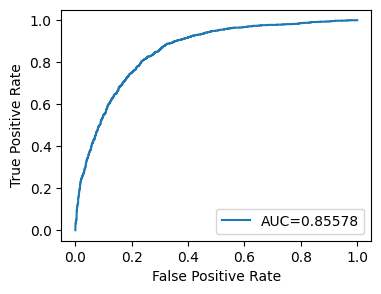

In [66]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.figure(figsize = (4, 3))
plt.rcParams["figure.dpi"] = 500
plt.plot(fpr,tpr,label="AUC="+str(np.round(auc, 5)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#create ROC curve


In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_train)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(np.round(auc, 5)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#create ROC curve


In [67]:
gmeans = np.sqrt(tpr * (1-fpr))

In [68]:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.406797, G-Mean=0.785


In [ ]:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

In [69]:
y_final = np.where(y_pred_proba >= 0.405119, 1, 0)

In [ ]:
best_clf

In [ ]:
metrics.plot_confusion_matrix(best_clf,X_test,y_test,cmap='Blues_r')


In [73]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=None,
                          title='Confusion Matrix', plot_numbers=False, display_names=None,
                          figsize=(15, 11)):

    cm = confusion_matrix(y_true, y_pred, labels=class_names, normalize=normalize)
    
    if not display_names:
        display_names = class_names
    df_cm = pd.DataFrame(cm, index=display_names, columns=display_names)
    plt.rcParams["figure.dpi"] = 500
    fig = plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=plot_numbers, cmap='Blues', fmt='g', cbar=False)
    plt.setp(plt.gca().get_xticklabels(), ha="right")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    return fig

In [ ]:
ax = plot_confusion_matrix(y_test, y_final, class_names=None, normalize='all',plot_numbers=True, figsize=(5, 5))

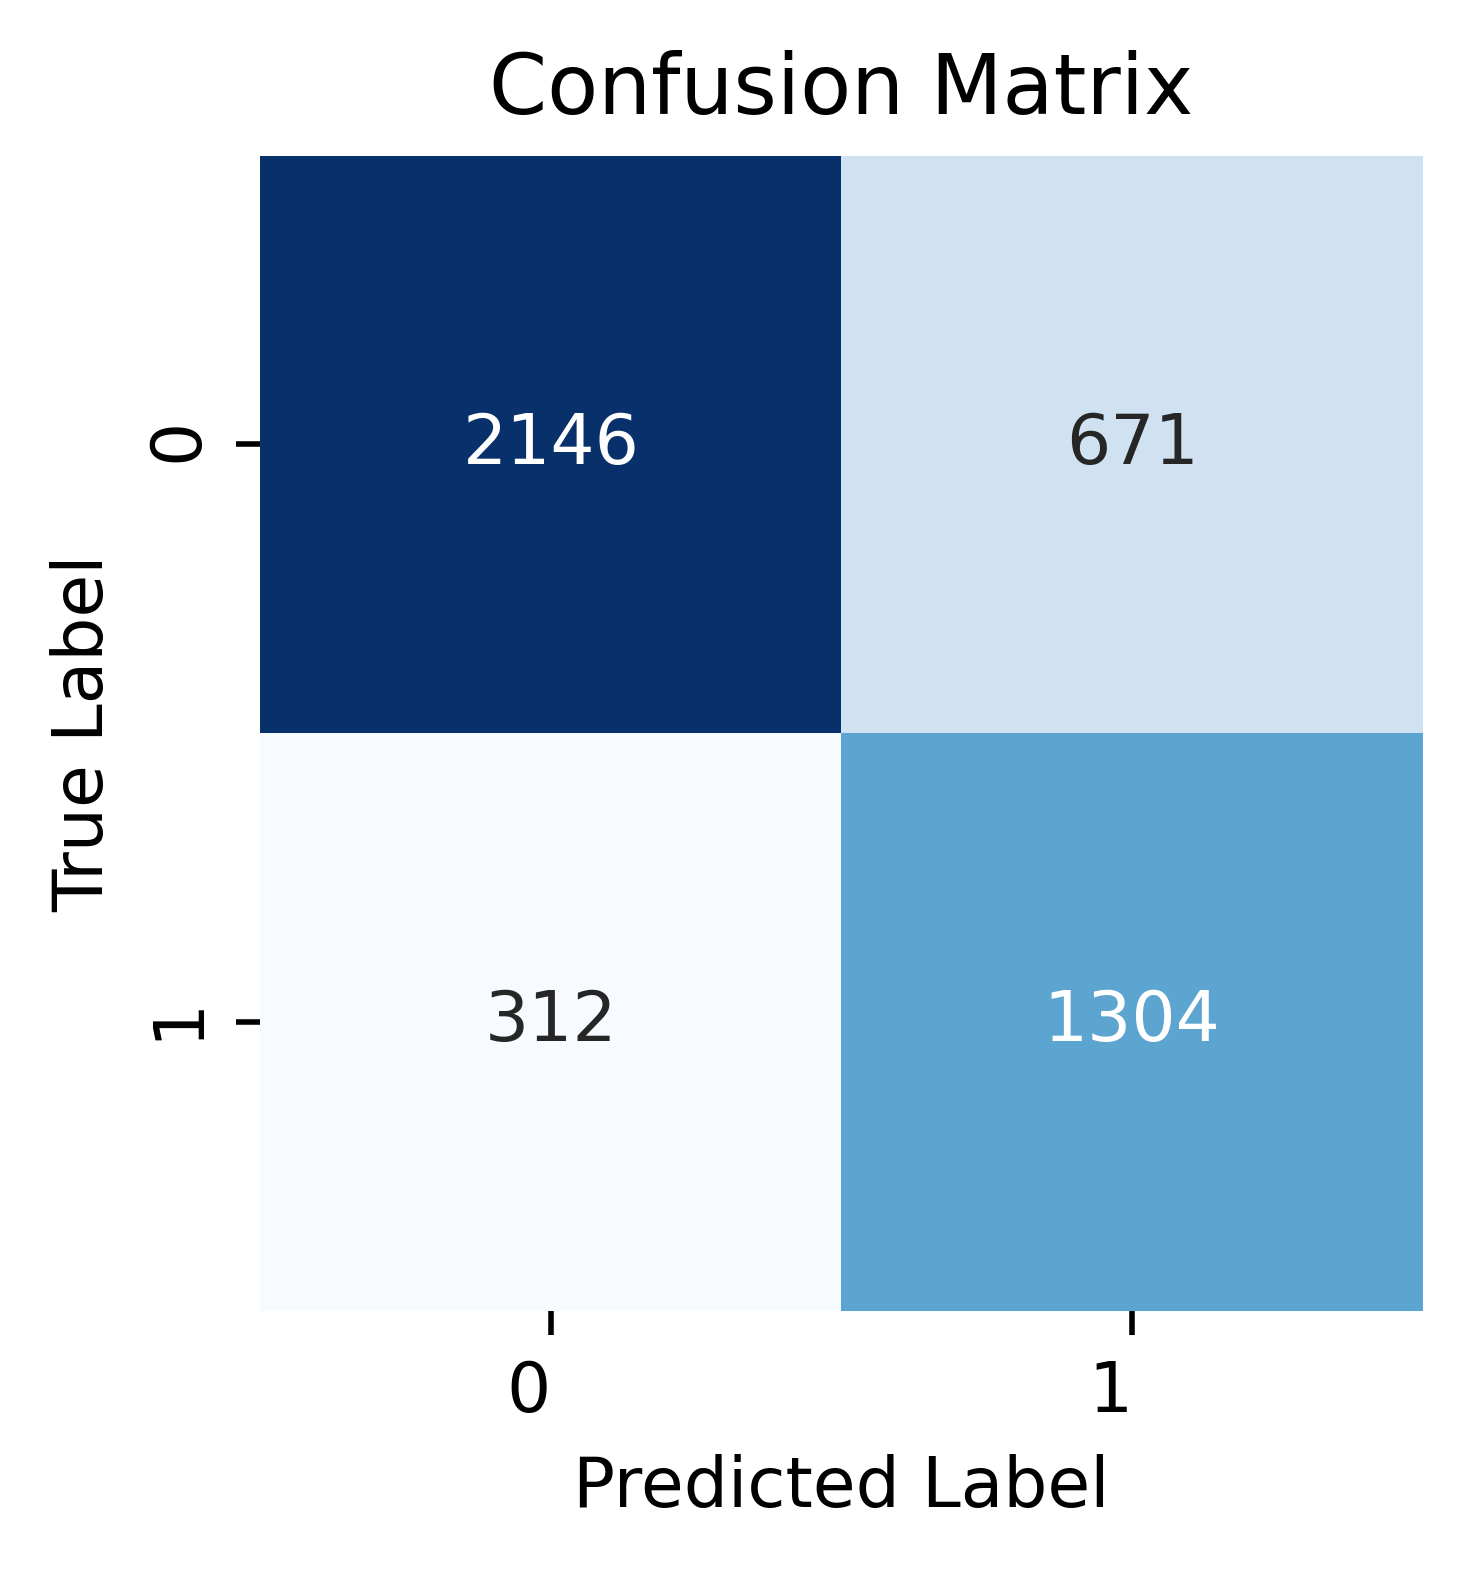

In [74]:
ax = plot_confusion_matrix(y_test, y_final, class_names=None, plot_numbers=True, figsize=(3, 3))

In [75]:
final_results = results.loc[X_test.loc[y_final == 1].index]
final_results.shape

(1975, 31)

In [76]:
final_results = final_results.sort_index()

In [77]:
len(match_loops (sip, final_results, window_size=2))

84

In [78]:
sip_test = sip.loc[~sip.Replica.isin(['0A', '2A', '5A', '8A'])]
chromosight_test = chromosight.loc[~chromosight.Replica.isin(['0A', '2A', '5A', '8A'])]


In [ ]:
len(final_results)

In [ ]:
plt.figure(figsize = (4, 4))
plt.rcParams["figure.dpi"] = 500
plt.style.use('default')
g = sns.scatterplot(x=[1242/1395, 2/1395, 69/1395], y=[21/3264, 2524/3264, 719/3264],)
g.set(xlim=(None, 1.01), ylim=(None, 1.01))

# plt.xlim(-100, 2600)
# plt.ylim(-100, 2600)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, color='grey', linestyle='--')
g.set_xlabel('pseudo FNR')
g.set_ylabel('pseudo FPR')
plt.text(1272/1395, 21/3264, "SIP", horizontalalignment='left', color='black',)
plt.text(32/1395, 2524/3264, "Chromosight", horizontalalignment='left', color='black',)
plt.text(99/1395, 719/3264, "TDA Caller", horizontalalignment='left', color='black',)
vals = g.get_yticks()
g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
vals = g.get_xticks()
g.set_xticklabels(['{:,.0%}'.format(x) for x in vals])

plt.show()

In [ ]:
plt.figure(figsize = (4, 4))
plt.rcParams["figure.dpi"] = 500
plt.style.use('default')
g = sns.scatterplot(x=[3230/3387, 429/3387, 1731/3387, 195/3387,], y=[18/5786, 959/5786, 383/5786, 4426/5786],)
g.set(xlim=(None, 1.01), ylim=(None, 1.01))

# plt.xlim(-100, 2600)
# plt.ylim(-100, 2600)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, color='grey', linestyle='--')
g.set_xlabel('pseudo FNR')
g.set_ylabel('pseudo FPR')
plt.text(3200/3387, 118/5786, "SIP", horizontalalignment='left', color='black',)
plt.text(399/3387, 1059/5786, "Chromosight", horizontalalignment='left', color='black',)
plt.text(1701/3387, 483/5786, "TDA Caller", horizontalalignment='left', color='black',)
plt.text(165/3387, 4526/5786, "LASCA", horizontalalignment='left', color='black',)
vals = g.get_yticks()
g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
vals = g.get_xticks()
g.set_xticklabels(['{:,.0%}'.format(x) for x in vals])

plt.show()

In [ ]:
len(sip_test)

In [ ]:
len(chromosight_test)

In [ ]:
len(match_loops (sip_test, chromosight_test, window_size=2))

In [ ]:
len(match_loops (final_results, chromosight_test, window_size=1))

In [ ]:
len(match_loops (final_results, chromosight_test, window_size=0))

In [ ]:
len(match_loops (final_results, chromosight_test, window_size=2))

In [ ]:
len(match_loops (final_results, chromosight_test, window_size=2))

In [ ]:
len(match_loops (sip_test.loc[match_loops (sip_test, chromosight_test, window_size=2)], final_results, window_size=2))

In [ ]:
len(match_loops (sip_test.loc[match_loops (sip_test, chromosight_test, window_size=2)], final_results, window_size=0))

In [ ]:
len(lasca)

In [ ]:
len(match_loops (sip_test, lasca, window_size=2))

In [ ]:
len(match_loops (chromosight_test, lasca, window_size=2))

In [ ]:
len(match_loops (final_results, lasca, window_size=2))

In [ ]:
len(match_loops (sip_test.loc[match_loops (sip_test, lasca, window_size=2)], final_results, window_size=2))

In [ ]:
len(match_loops (sip_test.loc[match_loops (sip_test, lasca, window_size=2)], chromosight_test, window_size=2))

In [ ]:
len(match_loops (chromosight_test.loc[match_loops (chromosight_test, lasca, window_size=2)], final_results, window_size=2))

In [ ]:
len(match_loops(sip_test.loc[match_loops (sip_test.loc[match_loops (sip_test, lasca, window_size=2)], chromosight_test, window_size=2)], final_results, window_size=2))

In [ ]:
len(match_loops (sip_test, chromosight_test, window_size=2))

In [ ]:
len(match_loops (sip_test, final_results, window_size=2))

In [ ]:
len(match_loops (chromosight_test, final_results, window_size=2))

In [ ]:
len(match_loops (sip_test.loc[match_loops (sip_test, chromosight_test, window_size=2)], final_results, window_size=2))

In [ ]:
lasca.loc[lasca.start2-lasca.start1>4000]

In [ ]:
chromosight.loc[chromosight.start2-chromosight.start1>6000]

In [ ]:
chromosight.loc[chromosight.start2-chromosight.start1==6000]

In [ ]:
final_results.loc[final_results.start2-final_results.start1==10000]

In [ ]:
(sip_test.start2-sip_test.start1).min()

In [ ]:
plt.figure(figsize = (10, 3))
plt.rcParams["figure.dpi"] = 500
plt.style.use('default')
ax = sns.violinplot(x='Range', y='Lifetime', data=results.loc[results.Range<=20])
# add_stat_annotation(ax, x=results['y'].astype('str'), y=results[col], order=['0', '1'],
#                 box_pairs=[('0', '1')],
#                 test='Mann-Whitney-gt', text_format='simple', loc='outside', verbose=2)
plt.show()


In [ ]:
lasca.start2-lasca.start2

In [79]:
import cooltools
cooltools??

In [ ]:
sip_test.loc[pd.Index(match_loops (sip_test, final_results, window_size=2))]

In [82]:
c = cooler.Cooler("/gss/home/a.kuznetsov/data_new/0B_2000_down.cool")
snipper =  cooltools.snipping.CoolerSnipper(c)

AttributeError: module 'cooltools' has no attribute 'snipping'

In [ ]:
tested_df = chromosight_test.loc[chromosight_test.Replica=='0B'][['chrom1', 'start1','chrom2', 'start2']]

In [ ]:
resolution = 2000
flank = 10000
windows1 = cooltools.snipping.make_bin_aligned_windows(
    resolution, 
    tested_df['chrom1'], 
    tested_df['start1'],
    flank_bp=flank)

windows2 = cooltools.snipping.make_bin_aligned_windows(
    resolution, 
    tested_df['chrom2'], 
    tested_df['start2'],
    flank_bp=flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows['region'] = windows['chrom1']


stack =  cooltools.snipping.pileup(
        windows, 
        snipper.select,
        snipper.snip)

In [ ]:
from matplotlib.colors import LogNorm
plt.figure(figsize = (5, 5))
plt.rcParams["figure.dpi"] = 500
im = plt.imshow(np.nanmean(stack, axis=2), cmap='coolwarm', vmax=0.05, vmin=0, )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(f'Pileup Plot of {tested_df.shape[0]} Loops\nChromosight')

In [ ]:
import cooltools.snipping

In [83]:
c = cooler.Cooler("/gss/home/a.kuznetsov/data_new/0B_2000_down.cool")


In [171]:
def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &(df.start2 - df.start1 > 4000) &
        (df.end2 < end), :
    ]
    subset.bin1 = (subset.start1 - start)/2000
    subset.bin2 = (subset.start2 - start)/2000
    return subset

In [126]:
(loops_sub.end2 - 5080000 )/ 2000

1142    11.0
1289    36.0
1445    49.0
1448    61.0
Name: end2, dtype: float64

In [172]:
# Select a region of interest
region = 'chr3:5080000-5240000'
mat = c.matrix(sparse=False, balance=True).fetch(region)


loops_sub = subset_region(final_results.loc[final_results.Replica == '0B'], region)
sip_sub = subset_region(sip.loc[sip.Replica == '0B'], region)
chromosight_sub = subset_region(chromosight.loc[chromosight.Replica == '0B'], region)
lasca_sub = subset_region(lasca.loc[lasca.Replica == '0B'], region)

# Make genome-based bin numbers relative to the region
# loops_sub.end_bin -= c.extent(region)[0]
# loops_sub.start_bin -= c.extent(region)[0]


In [169]:
lasca_sub

,index,chrom1,start1,end1,start2,end2,chrom2,Replica
912,912,chr3,5086000,5088000,5100000,5102000,chr3,0B
913,913,chr3,5114000,5116000,5148000,5150000,chr3,0B
914,914,chr3,5114000,5116000,5116000,5118000,chr3,0B
915,915,chr3,5114000,5116000,5152000,5154000,chr3,0B
916,916,chr3,5124000,5126000,5150000,5152000,chr3,0B
917,917,chr3,5128000,5130000,5162000,5164000,chr3,0B
918,918,chr3,5138000,5140000,5142000,5144000,chr3,0B
919,919,chr3,5154000,5156000,5178000,5180000,chr3,0B
920,920,chr3,5180000,5182000,5200000,5202000,chr3,0B
921,921,chr3,5200000,5202000,5228000,5230000,chr3,0B


In [166]:
lasca_sub = lasca_sub.loc[lasca_sub.start2 - lasca_sub.start1 > 4000]

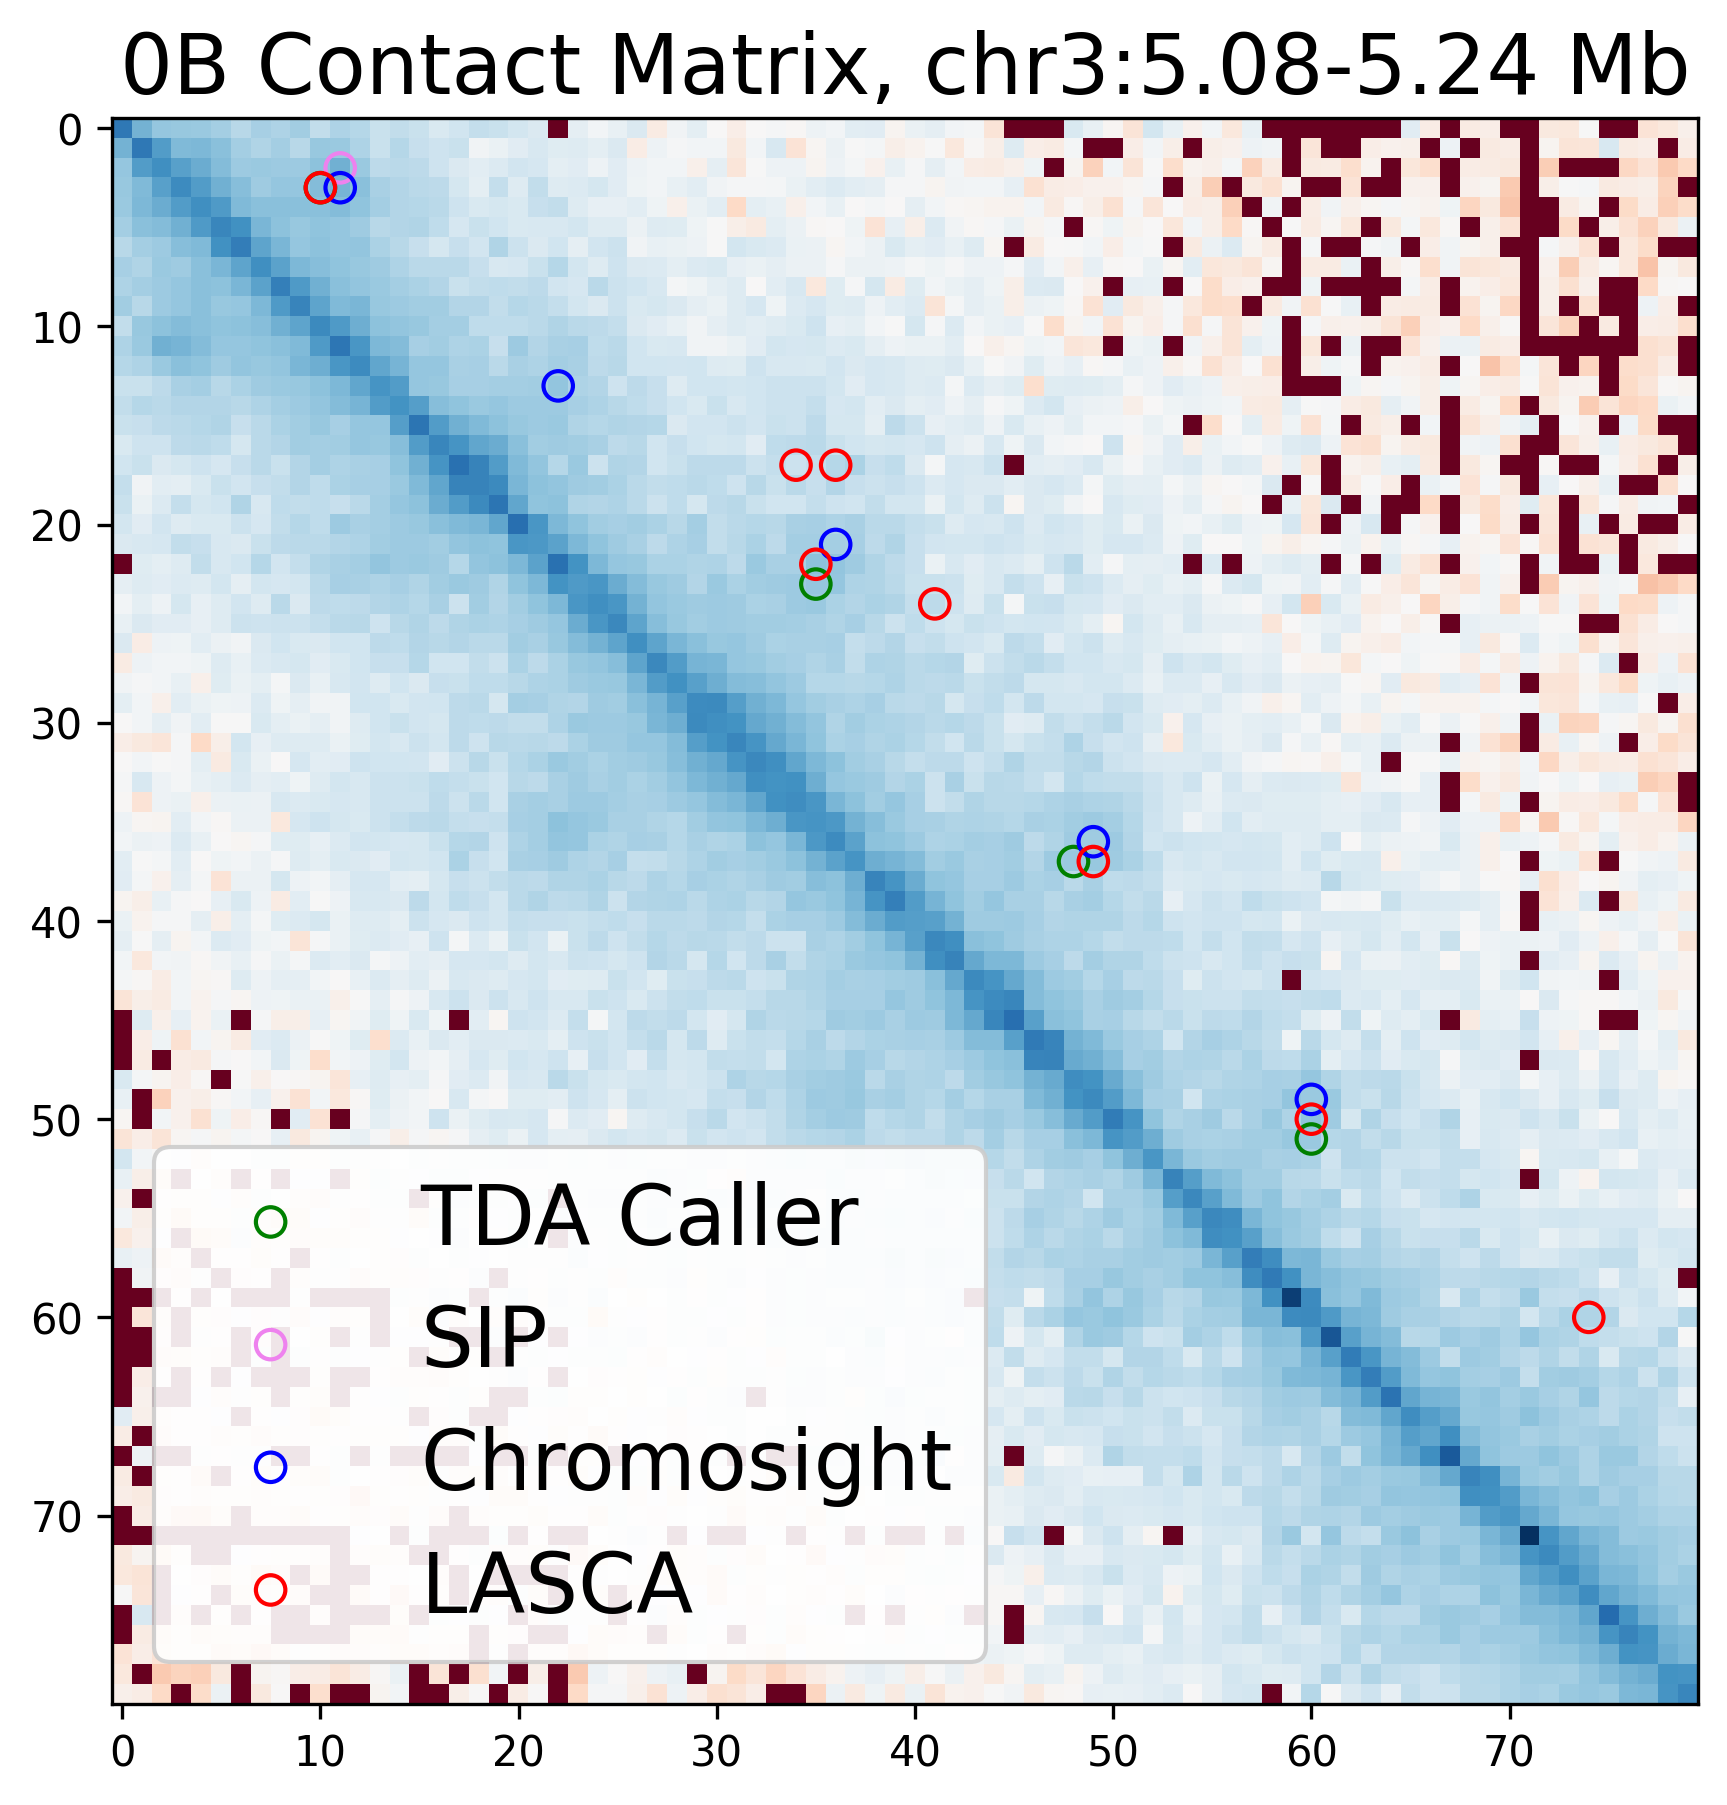

In [173]:
# %matplotlib inline
plt.figure(figsize=(7, 7))
plt.rcParams["figure.dpi"] = 300
plt.imshow(np.log10(mat+1e-6), cmap='RdBu')
plt.scatter(loops_sub.bin2, loops_sub.bin1, edgecolors='green', facecolors='none', label='TDA Caller', s=50)
plt.scatter(sip_sub.bin2, sip_sub.bin1, edgecolors='violet', facecolors='none', label='SIP', s=50)
plt.scatter(chromosight_sub.bin2, chromosight_sub.bin1, edgecolors='blue', facecolors='none', label='Chromosight', s=50)
plt.scatter(lasca_sub.bin2, lasca_sub.bin1, edgecolors='red', facecolors='none', label='LASCA', s=50)
# plt.axis('off')
plt.title('0B Contact Matrix, chr3:5.08-5.24 Mb', fontsize=20)
plt.legend(fontsize=20, framealpha=0.9)
plt.show()


In [ ]:
10160

In [ ]:
res

In [ ]:
model.score(X_test, y_test)

In [ ]:
data = []
for max_depth in range(1, 100):
    print(max_depth)
    clf = RandomForestClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_data = (max_depth, train_score, test_score)
    data.append(temp_data)
scores_data = pd.DataFrame(data, columns=['max_depth', 'train_score', 'test_score'])



In [ ]:
#BEFORE feature filtration
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)


In [ ]:
from sklearn.grids

In [ ]:
#After Feature Filtration
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
scores_data_long = pd.melt(scores_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)


In [ ]:
sns.lineplot(x='max_depth', y='test_score', data=scores_data)


In [ ]:
scores_data

In [ ]:
res

In [ ]:
sklearn feature selection

In [ ]:
#С ограничением  8
plt.figure(figsize = (5, 5))
plt.rcParams["figure.dpi"] = 500
plt.style.use('default')
(pd.Series(res['estimator'][3].feature_importances_, index=X.columns)
   .plot(kind='barh'))
plt.title('Random Forest Classifier Feature Importance')
plt.setp(plt.gca().get_yticklabels(), ha="right", rotation=45)


In [ ]:
#С ограничением  8
plt.figure(figsize = (6, 6))
plt.rcParams["figure.dpi"] = 400
plt.style.use('default')
(pd.Series(res['estimator'][3].feature_importances_, index=X.columns)
   .plot(kind='barh'))
plt.title('Random Forest Classifier Feature Importance')

In [ ]:
#С ограничением 3
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
(pd.Series(res['estimator'][3].feature_importances_, index=X.columns)
   .plot(kind='barh'))
plt.title('Random Forest Classifier Feature Importance, Max Depth = 3')

In [ ]:
fig = plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],           feature_names=X.columns,  
          filled=True, impurity=True, 
          rounded=True, fontsize=12)


In [ ]:
#С ограничением 5
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')

plt.figure(figsize = (10, 10))
(pd.Series(res['estimator'][3].feature_importances_, index=X.columns)
   .plot(kind='barh'))
plt.title('Random Forest Classifier Feature Importance, Max Depth = 5')

In [ ]:
fig = plt.figure(figsize=(40, 10))
plot_tree(model.estimators_[0],           feature_names=X.columns,  
          filled=True, impurity=True, 
          rounded=True, fontsize=8)


In [ ]:
#Без ограничения по глубине
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
(pd.Series(res['estimator'][3].feature_importances_, index=X.columns)
   .plot(kind='barh'))
plt.title('Random Forest Classifier Feature Importance, No Max Depth')

In [ ]:
fig = plt.figure(figsize=(40, 10))
plot_tree(model.estimators_[0],           feature_names=X.columns,  
          filled=True, impurity=True, 
          rounded=True, fontsize=8)

In [ ]:
res['test_score'].mean()

# Feature Correlation

In [ ]:
plt.figure(figsize = (8, 7))
plt.rcParams["figure.dpi"] = 500
plt.style.use('default')

sns.heatmap(X.corr(), cmap="vlag", annot=True, ).set_title('Crosscorrelation of Features')
plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
plt.setp(plt.gca().get_yticklabels(), ha="right", rotation=45)


In [ ]:
plt.figure(figsize = (12, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')

sns.heatmap(X.corr(), cmap="vlag", annot=True, ).set_title('Crosscorrelation of Features')


In [ ]:
X.head(10)

In [ ]:
results.head()

In [ ]:
np.round(all_distances[7][[4235, 4237, 4238, 4239, 4240], :][:, [4235, 4237, 4238, 4239, 4240]], 3)

In [ ]:
np.round(all_distances[7][[4235, 4236, 4237, 4238, 4239, 4240], :][:, [4235, 4236, 4237, 4238, 4239, 4240]], 3)

# Logistic Regression

In [ ]:
# параметры penalty, c, 

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
res = cross_validate(model, X_train, y_train, cv=5, scoring='accuracy', return_estimator=True)
res['estimator'][0].coef_

In [ ]:
model = LogisticRegression()
parametrs={'penalty':['l1', 'l2', 'elasticnet', 'none'], 'C': np.logspace(-2,2,30),}
grid_search_cv_clf=GridSearchCV(model, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

In [ ]:
model = LogisticRegression(C=2.212216291070448, penalty='l2')
model.fit(X_train, y_train)
model.score(X_test, y_test)

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

In [ ]:
grid_search_cv_clf.best_score_

In [ ]:
best_clf.coef_

In [ ]:
plt.figure(figsize = (5, 5))
plt.rcParams["figure.dpi"] = 500
plt.style.use('default')
(pd.Series(model.coef_[0], index=X.columns)
   .plot(kind='barh'))
plt.title('Logistic Regression Coefficients')

In [ ]:
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
(pd.Series(res['estimator'][0].coef_[0], index=X.columns)
   .plot(kind='barh'))
plt.title('Logistic Regression Coefficients')

In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.figure(figsize = (6, 4))
plt.rcParams["figure.dpi"] = 500
plt.plot(fpr,tpr,label="AUC="+str(np.round(auc, 5)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#create ROC curve


In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(np.round(auc, 5)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#create ROC curve


In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#create ROC curve


In [ ]:
y_pred_proba = model.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#create ROC curve


In [ ]:
#Без смертей:
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
(pd.Series(res['estimator'][0].coef_[0], index=X.columns)
   .plot(kind='barh'))

# LGBM

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)
res = cross_validate(model, X_test, y_test, cv=5, scoring='accuracy', return_estimator=True)
res

In [ ]:
data = []
for max_depth in range(1, 10):
    print(max_depth)
    clf = LGBMClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_data = (max_depth, train_score, test_score)
    data.append(temp_data)
lgbm_scores_data = pd.DataFrame(data, columns=['max_depth', 'train_score', 'test_score'])



In [ ]:
plt.figure(figsize = (10, 10))
plt.rcParams["figure.dpi"] = 100
plt.style.use('default')
lgbm_scores_data_long = pd.melt(lgbm_scores_data, id_vars = ['max_depth'], value_vars = ['train_score','test_score'], var_name = 'set_type', value_name = 'score')

sns.lineplot(x='max_depth', y='score', hue='set_type', data=lgbm_scores_data_long)


In [ ]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')

In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))


In [ ]:
import lightgbm as lgb
lgb.plot_importance(model)


In [ ]:
lgb.plot_metric(model)


In [ ]:
lgb.plot_tree(model,figsize=(30,40))


In [ ]:
from sklearn import metrics
metrics.plot_confusion_matrix(model,X_test,y_test,cmap='Blues_r')


In [ ]:
metrics.plot_confusion_matrix(model,X_train,y_train,cmap='Blues_r')


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test)))


In [ ]:
labels = ["0A", "0B", "2A", "2B", "5A", "5B", "8A", "8B"]
width = 0.9
first_order = chromosight.groupby('Replica').agg('count')['chrom1'].reindex(labels, fill_value=0)

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, first_order, width )

ax.set_ylabel('Found Loop Candidates')
ax.set_title('Chromosight Results Distribution', fontsize=20)

plt.show()


In [ ]:
first_order

In [ ]:
len(match_loops (sip, results, window_size=2))

In [ ]:
results

In [ ]:
width = 0.9
first_order = results[results.Dim == 1].groupby('Replica')["Dim"].agg('count').reindex(labels, fill_value=0)
second_order = results[results.Dim == 2].groupby('Replica')["Dim"].agg('count').reindex(labels, fill_value=0)

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, first_order, width,  label='1st order')
ax.bar(labels, second_order, width, bottom=first_order, label='2nd order')

ax.set_ylabel('Found Homologies')
ax.set_title('Homologies of the 1st and 2nd order by all maps.')
ax.legend()

plt.show()


In [ ]:
clr = cooler.Cooler("/gss/home/a.kuznetsov/data_new/0A_2000_down.cool")
clr.chromsizes

In [ ]:
nonbal = []
bal = []
for label in ['0A', '0B', '2A', '2B', '5A', '5B', '8A', '8B', ]:
    c = cooler.Cooler(f"/gss/home/a.kuznetsov/data_new/{label}_2000_down.cool")
    nonbal.append(c.matrix(balance=False)[:, :])
    bal.append(c.matrix(balance=True)[:, :])

In [ ]:
bal[0][saved_indices[0], :][:, saved_indices[0]].shape

In [ ]:
saved_indices[0][:15122]

In [ ]:
def plot_loop(contact_matrix, rep, loop_start, loop_end, margin = 50, scale_factor=2000, colorbar_display=False):
    plt.figure(figsize = (15, 15))
    start = max(0, loop_start-margin)
    end = min(saved_indices[rep].shape[0], loop_end+margin)
    frag = range(start, end)
    title=f'{labels[rep]} Balanced Contact Map Fragment, {np.round(dist_to_cont_bin(rep, start)*scale_factor/10**6, 2)}-{np.round(dist_to_cont_bin(rep, end)*scale_factor/10**6, 2)} Mb'
    plt.imshow(contact_matrix[rep][saved_indices[rep], :][:, saved_indices[rep]][frag, :][:, frag], cmap='RdBu',extent=[end,start,end,start])
    if colorbar_display:
        plt.colorbar()
    plt.title(title)

In [ ]:
results.loc[results.y==1].sort_values('Lifetime', ascending=False).head(10)

In [ ]:
results.loc[272]

In [ ]:
plot_loop(bal, 0, 10237, 10242, margin=10)

In [ ]:
def plot_loop_dot(contact_matrix, rep, loop_start, loop_end, margin = 50, scale_factor=2000, colorbar_display=False):
    start_x = max(0, loop_end-margin)
    end_x = min(saved_indices[rep].shape[0], loop_end+margin)
    start_y = max(0, loop_start-margin)
    end_y = min(saved_indices[rep].shape[0], loop_start+margin)
    frag_x = range(start_x, end_x)
    frag_y = range(start_y, end_y)
    title=f'{labels[rep]} Balanced Contact Map Fragment, {np.round(dist_to_cont_bin(rep, start_x)*scale_factor/10**6, 2)}-{np.round(dist_to_cont_bin(rep, end_x)*scale_factor/10**6, 2)} Mb'
    return contact_matrix[rep][saved_indices[rep], :][:, saved_indices[rep]][frag_x, :][:, frag_y]

In [ ]:
plot_loop_dot(bal, 0, 13282, 13294, margin=8).shape

In [ ]:
sip_test

In [ ]:
plot_loop_dot(bal, labels, 13282, 13294, margin=8).shape

In [ ]:
M = np.zeros((16, 16))
for x in match_loops (sip_test, final_results, window_size=0):
    M = np.add(M, plot_loop_dot(bal, labels.index(sip_test.loc[x, 'Replica']), int(sip_test.loc[x, 'start1']/2000), int(sip_test.loc[x, 'start2']/2000), margin=8), casting='unsafe')
print(M.shape)

In [ ]:
sns.heatmap(np.log10(M))

In [ ]:
plot_loop(bal, 0, 13282, 13294, margin=10)

In [ ]:
plot_loop(nonbal, 0, 13282, 13294, margin=10)

In [ ]:
import os
handy = pd.concat(list(map(lambda name: pd.read_csv('/gss/home/a.kuznetsov/loops_old/'+name, delimiter='\t'), os.listdir('loops_old'))), ignore_index=True)
handy

In [ ]:
loops_5_left = pd.read_csv('/gss/home/a.kuznetsov/loops_old/loops_5_left.bed', delimiter='\t', header=None, names=['chrom1', 'start1', 'end1'])
loops_1_6_left = pd.read_csv('/gss/home/a.kuznetsov/loops_old/loops_1_6_right.bed', delimiter='\t', header=None, names=['chrom1', 'start1', 'end1'])
loops_5_right = pd.read_csv('/gss/home/a.kuznetsov/loops_old/loops_5_right.bed', delimiter='\t', header=None, names=['chrom2', 'start2', 'end2'])
loops_1_6_right = pd.read_csv('/gss/home/a.kuznetsov/loops_old/loops_1_6_right.bed', delimiter='\t', header=None, names=['chrom2', 'start2', 'end2'])


In [ ]:
handy = pd.concat([pd.concat([loops_5_left, loops_1_6_left], ignore_index=True), pd.concat([loops_5_right, loops_1_6_right], ignore_index=True)], axis=1)
handy

In [ ]:
for rep in labels:
    handy['Replica'] = rep
    print(len(match_loops (handy, chromosight, window_size=2)))

In [ ]:
for rep in labels:
    handy['Replica'] = rep
    print(len(match_loops (handy, sip, window_size=2)))

In [ ]:
match_loops (handy, sip, window_size=2)